In [1]:
from nlpy.analysis import Analaysis
from manager import DBManager
from model import tweetModel
from gensim.models import Word2Vec

In [2]:
# 0.통일& 남북정상회담 관련 트위터 크롤링하기 2018-04-01-00:00:00
# cd crawler
# python3 tweetCrawler.py 남북정상회담 2018-04-01-00:00:00
# python3 tweetCrawler.py 통일 2018-04-01-00:00:00


# 1.크롤링한 트위터 정보에서 실제 남북 통일과 관련된 글만을 추려내기 위해(ex: 오늘 채색은 모든 색감을 통일해야겠어(통일과 관련없음.)) word2Vecotr로 통일 관련 단어들 추출해내기
tweets = tweetModel.getAllTweets()

# 실제 word2Vec에 쓰일 전체 voca
tokenized_contents = []
# 후에 negative한 vector값들판별하기 위한  id : tokenized_conetent값
data_contents = []
analysis = Analaysis()

for item in tweets:
    tweet_text = item["textt"]
    tokenized_tweet = analysis.getNounsList(tweet_text,1)
    tokenized_contents.append(tokenized_tweet)
    
    _tmp ={}
    _tmp["dataId"] = item["data_id"]    
    _tmp["tokenizedTweet"] = tokenized_tweet
    data_contents.append(_tmp)




In [16]:
# print(data_contents)

In [4]:
model = Word2Vec(tokenized_contents, size=100, window=5, min_count=1, workers=4)
# mostSimilar=> 코사인유사도를 측정해줌 => 백터간 거리
# 두 벡터의 방향을 보는데 그방향이 완전이 같으면 1 다르면-1을 낸다. 
meaning_word = model.wv.most_similar(positive=["통일"], topn=10033)

# 다양한 정보들을 아래서 확인 가능.
# words = list(model.wv.vocab)
# print(words)
# print(model['통일'])
# model.save('model.bin')
# load model
# new_model = Word2Vec.load('model.bin')
# print(new_model)

# 방향이 많이 틀어진 것들은 긍정 부정 검색에서 제외한다..
negative_word_arr =list(map(lambda x: x[0],filter(lambda x: x[1] <0, meaning_word)))
positive_word_arr =list(map(lambda x: x[0],filter(lambda x: x[1] >0.5, meaning_word)))

# print(negative_word_arr)
negative_contents_ids = []
for item in data_contents:
    positive_score =0;
    negative_score =0;
    
    for ele in item["tokenizedTweet"]:
        for ele2 in positive_word_arr:
            if ele == ele2:
                positive_score += 1;
                        
        for ele2 in negative_word_arr:
            if ele == ele2:
                negative_score +=1;
                if positive_score==0:
#                     print(positive_score)
#                     print(negative_score)                        
#                     print(item)                     
                    negative_contents_ids.append(item["dataId"]) 
                    
#       통일과 관련이 전혀 없는 애들 -값도 없고 상위 값도 없다.
        if positive_score == 0 and negative_score == 0:
#             print(positive_score)
#             print(negative_score)                        
#             print(item)         
            negative_contents_ids.append(item["dataId"]) 

#  관련없거나 -값인 애들은 긍정 부정 판별에서 제외시킨다.
for idd in negative_contents_ids:
    tweetModel.setTweetValid(idd)


In [11]:
# Google NaturalLanguage API전 단순 자체적인 Score를 이용한 Sentiment 판별
# a = Analaysis()
# valid_tweets = tweetModel.getAllValidTweets()
# for item in valid_tweets:
#     print(item["textt"])
#     nlpy_sentence = a.getNounsList(item["textt"])
#     print(a.checkSentiment(nlpy_sentence))

In [ ]:
# Google NaturalLanguage 사용버전.
# 필터링된 데이터(1289개)에대한 sentiment정보를 가져온다.
#  8분 30 초정도 
# magnitude: 정규화 되지않는 값. 텍스트가 길어질수록 값이 커질 수 있다.
# score: -1 1 사이로 정규화된값.
valid_tweets = tweetModel.getAllValidTweets()
for item in valid_tweets:    
    senti_result = analysis.checkSentimentByGoogle(item["textt"])
    tweetModel.setTweetSentiment(item["data_id"],senti_result["score"],senti_result["magnitude"])	


All Tweet Cnt: 1778
filtered Tweet Cnt: 1289
good : 530
normal : 599
bad : 166


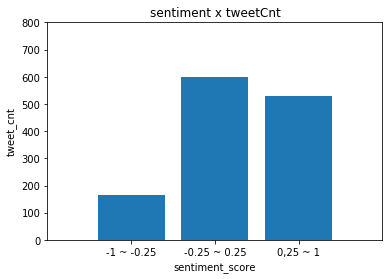

<Figure size 432x288 with 0 Axes>

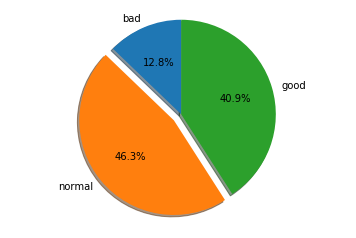

<Figure size 432x288 with 0 Axes>

In [37]:
# 결과를 추려서 그래프로 그려보자.
import numpy as np
import matplotlib.pyplot as plt

bad_cnt = tweetModel.getSegmentBad()[0]["bad"]
good_cnt = tweetModel.getSegmentGood()[0]["good"]
normal_cnt = tweetModel.getSegmentNoraml()[0]["normal"]

print("All Tweet Cnt: 1778")
print("filtered Tweet Cnt: 1289")
print("good : "+str(good_cnt))
print("normal : "+str(normal_cnt))
print("bad : "+str(bad_cnt))

y1_value = [bad_cnt,normal_cnt,good_cnt]
x_name=['-1 ~ -0.25', '-0.25 ~ 0.25','0,25 ~ 1']
n_groups = len(x_name)
index = np.arange(n_groups)
plt.bar(index, y1_value, tick_label=x_name, align='center')

plt.xlabel('sentiment_score')
plt.ylabel('tweet_cnt')
plt.title('sentiment x tweetCnt')
plt.xlim( -1, n_groups)
plt.ylim( 0, 800)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('result1.png', dpi=100)

labels = 'bad', 'normal', 'good'
sizes = [bad_cnt,normal_cnt,good_cnt]
# explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1 = plt.gcf()
plt.show()
plt.draw()

fig1.savefig('result2.png', dpi=100)





In [ ]:
# !OPTION 통일관련 Word2Vector 모델링 된것을 그래프로 보기
# PCA 차원축소 고차원벡터 =>처차원 
from sklearn.decomposition import PCA
from matplotlib import pyplot
import matplotlib.font_manager as fm

import matplotlib
import matplotlib.font_manager

# 한글처리를 위해 폰트 위치 찾기
# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
# [(f.name, f.fname) for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

# 찾은 폰트로 plot 한글표기 가능하도록 설정
path = '/Library/Fonts/NanumBarunGothic-YetHangul.ttf'
fontprop = fm.FontProperties(fname=path, size=0.5)

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.scatter(result[:, 0], result[:, 1],1)

words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]),fontproperties=fontprop)

fig1 = pyplot.gcf()
pyplot.show()
pyplot.draw()
fig1.savefig('uni_w2c.png', dpi=2000)
    
